Something has to be wrong with what plastid is doing here, the total counts for ribosome profiling reads from that table are greater then the total number of counts for the original data itself! The whole thing seems... backwards. And the RNA seq counts from the table are like, 30 times smaller than the one from the dataset?

## Importing packages and defining the path

In [29]:
import sys
sys.path.append('/home/keeganfl/Desktop/Work_Fall_2021/Fall_2021_Work_journal/tools/')

In [30]:
# import plastid
# data structure for mapping read alignments to genomic positions
from plastid import BAMGenomeArray, GenomeArray, VariableFivePrimeMapFactory, \
                        GTF2_TranscriptAssembler, GFF3_TranscriptAssembler, \
                        Transcript, ThreePrimeMapFactory, CenterMapFactory
import plastid
from plastid.plotting.plots import *
import numpy as np
import os
from Bio import SeqIO
import numpy
import math
import pandas as pd
from scipy import stats
import keegan_analysis_tools as kat
from statsmodels.nonparametric.smoothers_lowess import lowess
import warnings
import matplotlib.pyplot as plt
%matplotlib inline
import csv
from scipy.sparse.linalg import lsqr

In [38]:
# Define the path to our Bam files
data_path = "/home/keeganfl/Desktop/Work_Fall_2021/genomes_&_samples/dmel/"
feat_counts_path = "/home/keeganfl/Desktop/Work_Fall_2021/feature_counts/dmel/"
save_path = "/home/keeganfl/Desktop/Work_Fall_2021/data_tables/TE_tables/dmel/"
p_site_path = "/home/keeganfl/Desktop/Work_Fall_2021/data_tables/p-site_offsets/dmel/"
gtf_name = "Drosophila_melanogaster.BDGP6.32.103.gtf"
mutation = 'control'
samp_num = '2'
special = "fc"
if os.path.isfile(save_path + mutation + '_' + samp_num + '_' + "te_table" + special + ".csv") == True:
    pre_load = True
else:
    pre_load = False

## Loading in the ribosome profiling data with plastid

In [32]:
# Load up genome annotation as a list of transcript objects
gtf_reads=list(GTF2_TranscriptAssembler(open(data_path + gtf_name),return_type=Transcript))

In [33]:
# Open the read alignments, storing each dataset in a BAMGenomeArray:
my_datasets = { "ribosome_profiling" : data_path + mutation +"_RPF_" + samp_num + "_Aligned.sortedByCoord.out.bam"
              }

my_datasets = { K : BAMGenomeArray(V) for K,V in my_datasets.items() }

In [34]:
# Load in the table of P-site offsets. 
p_offsets=pd.read_csv(p_site_path + mutation + '_RPF_' + samp_num + "_Aligned.toTranscriptome.out_p-site-offsets", sep="\t")

# Map the ribosome profiling alignments to the p-site. 
my_datasets["ribosome_profiling"].set_mapping(kat.VariableThreePrimeMapFactory(p_offsets=p_offsets))

In [35]:
# we will calculate both total counts and RPKM
metrics = ("counts","rpk","lengths")

# create an empty list for each sample and metric
my_data = { "%s_%s" % (SAMPLE,METRIC) : copy.deepcopy([])\
                                                  for SAMPLE in my_datasets.keys()\
                                                  for METRIC in metrics }

# add a list to our dictionary of lists to store transcript IDs
my_data["transcript_ID"] = []
my_data["gene_name"] = []
my_data["gene_ID"] = []

for transcript in gtf_reads:
        
    # First, save ID of transcript we are evaluating
    if transcript.attr["transcript_biotype"] == "protein_coding":
        my_data["transcript_ID"].append(transcript.get_name())
        my_data["gene_ID"].append(transcript.attr["gene_id"])
        my_data["gene_name"].append(transcript.attr["gene_name"])

        # Iterate over each sample
        for sample_name, sample_data in my_datasets.items():
            # transcript.get_counts() fetches a list of counts at each position
            # here we just want the sum
            counts = sum(transcript.get_counts(sample_data))
            length = transcript.length
            rpk   = float(counts)/(length/1000)
            my_data["%s_counts" % (sample_name)].append(counts)
            my_data["%s_rpk"   % (sample_name)].append(rpk)
            my_data["%s_lengths" % (sample_name)].append(length)

In [61]:
# convert to Dataframe
df = pd.DataFrame(my_data)

## Loading RNA sequencing data from feature counts

In [62]:
#Load in feature counts data
feature_counts = pd.read_csv(feat_counts_path + 'counts_' + mutation + '_RNA_' + samp_num + '.txt', delimiter = "\t", comment='#')

In [63]:
# Select our columns of interest. 
cols = ["Geneid","Length",mutation + '_RNA_' + samp_num + "_Aligned.sortedByCoord.out.bam"]
feature_counts = feature_counts[cols]

In [64]:
# Rename our columns to assist with the merge to the dataframe. 
feature_counts.rename(columns = {mutation + '_RNA_' + samp_num + "_Aligned.sortedByCoord.out.bam" : "RNA-seq_counts",
                                "Length" : "RNA-seq_lengths", "Geneid" : "gene_ID"}, inplace = True)

In [65]:
# create new columns that contain the calculations for tpm and rpkm. 
feature_counts["RNA-seq_rpk"] = feature_counts["RNA-seq_counts"]/feature_counts["RNA-seq_lengths"]
feature_counts["RNA-seq_tpm"] = feature_counts["RNA-seq_rpk"]/(sum(feature_counts["RNA-seq_rpk"])/1e6)
feature_counts["RNA-seq_rpkm"] =feature_counts["RNA-seq_counts"]/ feature_counts["RNA-seq_lengths"]*1000 * 1e6 / sum(feature_counts["RNA-seq_counts"])

In [66]:
#
df_merged = pd.merge(df,feature_counts, how = "inner", on = "gene_ID")

In [67]:
df = df_merged

# Estimating translation efficiency

In [68]:
#df["RNA-seq_rpk"] = df["RNA-seq_counts"]/(df["ribosome_profiling_lengths"]/1000)
df["ribosome_profiling_rpk"] = df["ribosome_profiling_counts"]/(df["ribosome_profiling_lengths"]/1000)


# Calculate tpm using rpk from our new dataframe. 
for sample_name in ["ribosome_profiling"]:
    per_m_s = sum(df["%s_rpk"   % (sample_name)])/1e6
    df["%s_tpm" % (sample_name)] = (df["%s_rpk"   % (sample_name)])/per_m_s
    
# Calculate rpkm using the read counts. Work in progress.
for sample_name in ["ribosome_profiling"]:
    counts = df["%s_counts"   % (sample_name)]
    rpkm   = counts / df["ribosome_profiling_lengths"]*1000 * 1e6 / sum(counts)
    df["%s_rpkm" % (sample_name)] = rpkm
    
    
# Calculate translation efficiency using tpm
df["TE_tpm"] = df["ribosome_profiling_tpm"] / df["RNA-seq_tpm"]

# Calculate translation efficiency using rpkm
df["TE_rpkm"] = df["ribosome_profiling_rpkm"] / df["RNA-seq_rpkm"]

In [69]:
# Rearranging Column names to make something more readable. 
cols = ['transcript_ID', "gene_ID","gene_name", 'TE_tpm','TE_rpkm','ribosome_profiling_tpm',
        'RNA-seq_tpm','ribosome_profiling_counts','RNA-seq_counts',
        'ribosome_profiling_rpkm', 'RNA-seq_rpkm', 'ribosome_profiling_rpk', 
       'RNA-seq_rpk', 'ribosome_profiling_lengths', 'RNA-seq_lengths']
df = df[cols]

In [70]:
# save the data frame.
if pre_load == False:
    df.to_csv(save_path + mutation + '_' + samp_num + '_' + "te_table" + special + ".csv", index = False)

In [71]:
#!# A line of code that quickly loads up the data if it has already been saved. 
if pre_load == True:
    df = pd.read_csv(save_path + mutation + '_' + samp_num + '_' + "te_table" + special + ".csv")

## Distribution of translation efficiency

In [26]:
# We need to remove zeroes and infinite values in order to make the kernel density estimates
df_clean=df[~df.isin([np.nan, np.inf, -np.inf, 0]).any(1)]

# We are only going to look at TE values that fall within a certain region. 
df_interest=df_clean[(df_clean["TE_tpm"] >= 0)&(df_clean["TE_tpm"] <= 800)]

(0.0, 20.0)

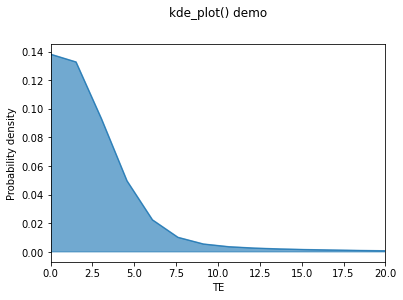

In [27]:
# plot kernel density estimates of A and B on the same axis
fig, ax = kde_plot(df_interest["TE_tpm"],label="TE")

# make things look nice
plt.xlabel("TE")
plt.ylabel("Probability density")
plt.title("kde_plot() demo",y=1.1)
plt.xlim(0,20)

## Translation levels vs transcription levels

Text(0, 0.5, 'Translation (tpm of footprints over CDS)')

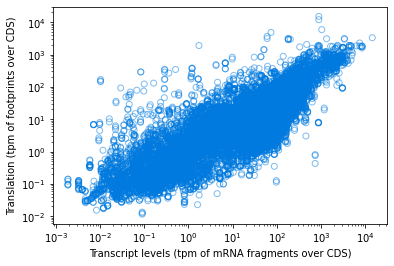

In [25]:
my_figure = plt.figure()
plt.loglog() # log-scaling makes it easier

# make a copy of dataframe for plotting
# this is because 0-values cannot be plotted in log-space,
# so we set them to nan so they are ignored. 

MIN_VAL = np.nan
plot_df = copy.deepcopy(df)
plot_df["RNA-seq_tpm"].replace({0:MIN_VAL}, inplace=True)
plot_df["ribosome_profiling_tpm"].replace({0:MIN_VAL}, inplace=True)

# now, make a scatter plot
plt.scatter(plot_df["RNA-seq_tpm"],
            plot_df["ribosome_profiling_tpm"],
            marker="o",alpha=0.5,facecolor="none",edgecolor="#007ADF")
plt.xlabel("Transcript levels (tpm of mRNA fragments over CDS)")
plt.ylabel("Translation (tpm of footprints over CDS)")

## Translation efficiency vs transcript levels.

<module 'matplotlib.pyplot' from '/home/keeganfl/miniconda3/envs/plastid/lib/python3.8/site-packages/matplotlib/pyplot.py'>

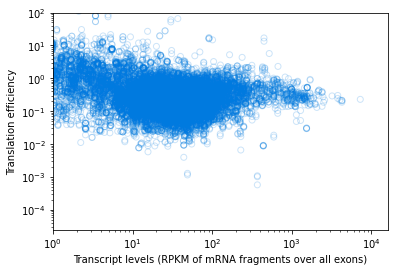

In [28]:
plt.loglog()
plot_df = copy.deepcopy(df)
plot_df["RNA-seq_rpkm"].replace({0:MIN_VAL}, inplace=True)
plot_df["ribosome_profiling_rpkm"].replace({0:MIN_VAL}, inplace=True)

# now, make a scatter plot
plt.scatter(plot_df["RNA-seq_rpkm"],
            plot_df["TE_tpm"],
            marker="o",alpha=0.2,facecolor="none",edgecolor="#007ADF")
plt.xlabel("Transcript levels (RPKM of mRNA fragments over all exons)")
plt.ylabel("Translation efficiency")
plt.xlim(1,plt.xlim()[1])
plt.ylim(plt.ylim()[0]/10.0,100)

plt